In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def load_pkl(name, data_dir="simulation_data"):
    with open(os.path.join(data_dir, name), "rb") as f:
        return pickle.load(f)

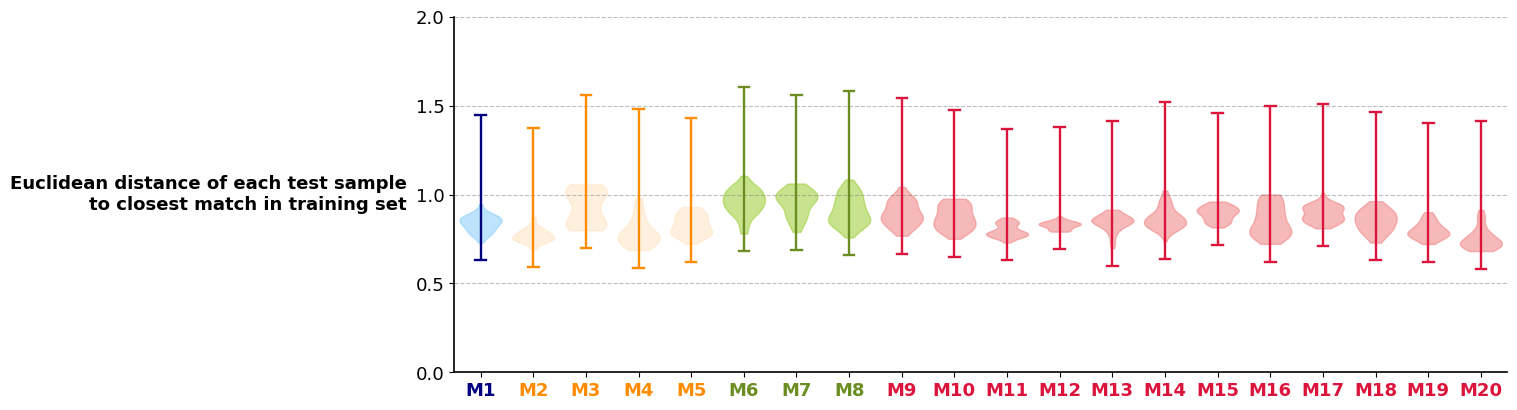

In [122]:
def plot_euclidean_violin(data_dir="simulation_data"):
    x2_train = load_pkl("x2_train_M1_M20_train_val_test_set.pkl", data_dir)
    y_train = load_pkl("y_train_M1_M20_train_val_test_set.pkl", data_dir)
    x2_test_dict = load_pkl("x2_test_M1_M20_train_val_test_set.pkl", data_dir)
    y_test = load_pkl("y_test_M1_M20_train_val_test_set.pkl", data_dir)
    
    test_npts = 7
    test_noise = 1

    if isinstance(x2_test_dict, dict):
        if str(test_npts) in x2_test_dict:
            x2_test_dict = x2_test_dict[str(test_npts)]
        elif test_npts in x2_test_dict:
            x2_test_dict = x2_test_dict[test_npts]
        else:
            raise ValueError(f"No test set for {test_npts} points in x2_test_dict")
        if str(test_noise) in x2_test_dict:
            x2_test = x2_test_dict[str(test_noise)]
        elif test_noise in x2_test_dict:
            x2_test = x2_test_dict[test_noise]
        else:
            raise ValueError(f"No noise={test_noise} in x2_test_dict[{test_npts}]")
    else:
        x2_test = x2_test_dict

    y_train = np.array(y_train)
    y_test = np.array(y_test)
    if y_train.ndim == 2 and y_train.shape[1] == 20:
        y_train = np.argmax(y_train, axis=1)
    elif y_train.ndim == 2 and y_train.shape[1] == 1:
        y_train = y_train.flatten()
    if y_test.ndim == 2 and y_test.shape[1] == 20:
        y_test = np.argmax(y_test, axis=1)
    elif y_test.ndim == 2 and y_test.shape[1] == 1:
        y_test = y_test.flatten()

    mech_names = [f"M{i+1}" for i in range(20)]
    violin_data = []
    for mech_idx, mech_name in enumerate(mech_names):
        train_idx = np.where(y_train == mech_idx)[0]
        test_idx = np.where(y_test == mech_idx)[0]
        if len(train_idx) == 0 or len(test_idx) == 0:
            violin_data.append([])
            continue
        train_flat = x2_train[train_idx].reshape(len(train_idx), -1)
        test_flat = x2_test[test_idx].reshape(len(test_idx), 7, 12)
        dists = []
        for i in range(test_flat.shape[0]):
            x_test = test_flat[i]
            x_interp = []
            for j in range(12):
                f = interp1d(np.linspace(0, 1, 7), x_test[:, j], kind='linear', fill_value='extrapolate')
                x_interp.append(f(np.linspace(0, 1, 21)))
            x_interp = np.stack(x_interp, axis=1).reshape(-1)
            dists_i = np.sqrt(((train_flat - x_interp) ** 2).sum(axis=1))
            dists.append(np.min(dists_i))
        violin_data.append(dists)

    plt.figure(figsize=(13, 4.5))
    palette = ['navy'] + ['darkorange']*4 + ['olivedrab']*3 + ['crimson']*12

    parts = plt.violinplot(
        violin_data, showmeans=False, showmedians=False, showextrema=False, widths=0.8,
        bw_method=0.5
    )
    for i, pc in enumerate(parts['bodies']):
        if i == 0:
            color = 'lightskyblue'
        elif 1 <= i <= 4:
            color = 'bisque'
        elif 5 <= i <= 7:
            color = 'yellowgreen'
        else:
            color = 'lightcoral'
        pc.set_facecolor(color)
        pc.set_edgecolor(color)
        pc.set_alpha(0.55)
    for i, data in enumerate(violin_data):
        if len(data) == 0: continue
        minv, maxv = min(data), max(data)
        center = i + 1
        extend_top = 0.5
        extend_bot = 0.1 
        plt.plot([center, center], [minv-extend_bot, maxv+extend_top], color=palette[i], lw=1.7, zorder=10, solid_capstyle='butt')
        capw = 0.2
        plt.plot([center-capw/2, center+capw/2], [minv-extend_bot, minv-extend_bot], color=palette[i], lw=1.7, zorder=11)
        plt.plot([center-capw/2, center+capw/2], [maxv+extend_top, maxv+extend_top], color=palette[i], lw=1.7, zorder=11)
    plt.xticks(np.arange(1, 21), [f"M{i}" for i in range(1, 21)], fontsize=13, fontweight="bold")
    for i, xtick in enumerate(plt.gca().get_xticklabels()):
        xtick.set_color(palette[i])
    plt.xlim(0.5, 20.5)
    plt.ylim(0, 2)
    plt.tick_params(axis='y', labelsize=13)
    plt.yticks(np.arange(0, 2.5, 0.5))
    plt.grid(axis='y', linestyle='--', color='gray', alpha=0.5)
    plt.subplots_adjust(left=0.18, bottom=0.20, top=0.99, right=0.99)
    plt.gca().spines['left'].set_linewidth(1.2)
    plt.gca().spines['bottom'].set_linewidth(1.2)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlabel("")
    plt.ylabel(
        "Euclidean distance of each test sample\n"
        "to closest match in training set",
        fontsize=13, fontweight="bold", rotation=0, labelpad=44, ha='right', va='center'
    )
    plt.gca().yaxis.set_label_coords(-0.045, 0.5)
    plt.savefig(os.path.join(data_dir, "euclidean_violin.pdf"), format="pdf", bbox_inches=None)
    plt.show()

plot_euclidean_violin("simulation_data")